In [13]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Create a 3D tensor of zeros directly on the GPU
    randn_tensor_gpu1 = torch.randn((3, 2, 4), device='cuda')
else:
    print("CUDA is not available. Tensor will be created on CPU.")
    randn_tensor_gpu2 = torch.randn((800, 800, 800))


CUDA is not available. Tensor will be created on CPU.


In [14]:
torch.cuda.is_available()

False

In [ ]:
# Get Markdown working and maybe add the tensorboard thing
# Add the device to the 
# Deleting plot but just keep the same one everytime. 
# Getting parameters right and running 
# Running for 500 epochs (goal)
# Get this going tomorrow. 

# Jobs to ARGON
# random spatial cropped
# Center spatial cropped
# Add device thing for argon


# Detach some stuff including the loss: loss.detach() or loss.tocpu()
# Also must adjust the number of training and validation images
# Should we load and save the optimizer?
# Patch size needs to be changed beore sending
# Might send the center spatial and random spatial transformation
# Might need to change batch size for training data
#  num_res_units=2?
# to_onehot_y=True ?
# Learning rate shceduling (LATER): cosine annealing
# Num epochs to be changed for argon
#Delete Image folder and visualization

In [ ]:
print("Importing Modules")
import os
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, CenterSpatialCropd,\
                               RandRotate90d, ToTensord, ScaleIntensityRanged, SpatialPadd)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader, pad_list_data_collate
print("Monai imported. Importing Torch")
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import time 
import numpy as np

md_file_path = "./visualization.md"


starttime = time.time()
# image_folder = "./PNG/"

# if os.path.exists(md_file_path):
#     os.remove(md_file_path)

# if os.path.exists(md_file_path):
#     PNG

print("Defining the create_dataset function...")
# Function to create dataset
def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

print("Setting data paths...")
# Set data paths
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet(NEWTRY).pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet_optimizer(NEWTRY).pth"

print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest') ###############################################################
)

# Define the size of the cropped region
roi_size = (128, 128, 128)
# roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, #####################################################################
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])


print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True) #collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=4) #collate_fn=pad_list_data_collate)


print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     num_gpus = torch.cuda.device_count()
#     print(f"Number of available GPUs: {num_gpus}")
#     if num_gpus > 1:
#         net = torch.nn.DataParallel(net)  # Wrap the model with DataParallel
#     net.to(device)
# else:
#     device = torch.device("cpu")
#     net.to(device)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #########################################
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1500, eta_min=1e-6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")


print("Setting up loss function and optimizer...")

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'TRAINING-{num_train}', fontsize=16)
                img_path = f"./PNG/TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'VALIDATION-{num}', fontsize=16)
                img_path = f"./PNG/VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/lossfunction.png")
    plt.close()

# Loss Plotting Function
def plot_losses_log(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/log-lossfunction.png")
    plt.close()



# Main training loop
num_epochs = 5 # Example value
display_interval = 1 # Example value


def train_step(batch_data, model, loss_function, optimizer, device):
    # print("Reading in the images")
    # print(f"Processing filenames: {batch_data['filename']}")
    images, labels = batch_data['image'], batch_data['label']
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)

    print(f"Output shape: {outputs.shape}, Label shape: {labels.shape}")
    print("Label tensor values (sample):", labels[0, :, 0, 0, 0])
    # if torch.any(labels == 3):
        # print(f"Filename with label 3: {batch_data['filename']}")

    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs


train_losses = []
val_losses = []
print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    

    # Training Phase
    net.train()
    num_train = 0
    print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
    print("\nReading in the first batch - T ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer, device)
        epoch_train_loss += loss
        # if iteration % display_interval == 0:
        if (epoch + 1) % 1 == 0 or epoch == 0:
            visualize_and_save_train(batch_data['image'], output, batch_data['label'], iteration, epoch, num_train) 
        print("\nReading in the next batch - T [if any] ..")
        num_train = num_train + 1
    train_losses.append(epoch_train_loss / len(train_loader))
    print("Running the validation loop ..")
    
    # Validation Phase
    net.eval()
    num = 0
    with torch.no_grad():
        print("Reading in the first batch - V ..")
        for batch_data in val_loader:
            print(f"Validation Iteration: {num}")
            # print(f"Processing filenames: {batch_data['filename']}")
            images, labels = batch_data['image'], batch_data['label']
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            print(f"Validation - Output shape: {outputs.shape}, Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            # if iteration % display_interval == 0:
            if (epoch + 1) % 1 == 0 or epoch == 0:
                visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], iteration, epoch, num) 
            print("Reading in the next batch - V [if any] ..")
            num = num + 1
        print()    
    
    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step()
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch: {epoch}, Current Learning Rate: {current_lr}")
    # Plot Losses
    print("Plotting losses ..")
    plot_losses(train_losses, val_losses)
    plot_losses_log(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# plt.ioff()  # Turn off interactive mode
# plt.show()  # Display final plots

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")



In [ ]:
The 'colormap' trait of an IsoSurfaceFactory instance must be 'Accent' or 'Blues' or 'BrBG' or 'BuGn' or 'BuPu' or 'CMRmap' or 'Dark2' or 'GnBu' or 'Greens' or 'Greys' or 'OrRd' or 'Oranges' or 'PRGn' or 'Paired' or 'Pastel1' or 'Pastel2' or 'PiYG' or 'PuBu' or 'PuBuGn' or 'PuOr' or 'PuRd' or 'Purples' or 'RdBu' or 'RdGy' or 'RdPu' or 'RdYlBu' or 'RdYlGn' or 'Reds' or 'Set1' or 'Set2' or 'Set3' or 'Spectral' or 'Vega10' or 'Vega20' or 'Vega20b' or 'Vega20c' or 'Wistia' or 'YlGn' or 'YlGnBu' or 'YlOrBr' or 'YlOrRd' or 'afmhot' or 'autumn' or 'binary' or 'black-white' or 'blue-red' or 'bone' or 'brg' or 'bwr' or 'cool' or 'coolwarm' or 'copper' or 'cubehelix' or 'file' or 'flag' or 'gist_earth' or 'gist_gray' or 'gist_heat' or 'gist_ncar' or 'gist_rainbow' or 'gist_stern' or 'gist_yarg' or 'gnuplot' or 'gnuplot2' or 'gray' or 'hot' or 'hsv' or 'inferno' or 'jet' or 'magma' or 'nipy_spectral' or 'ocean' or 'pink' or 'plasma' or 'prism' or 'rainbow' or 'seismic' or 'spectral' or 'spring' or 'summer' or 'terrain' or 'viridis' or 'winter',

In [ ]:
# Problems to be fixed
# input volume should be ct image,,, when showing that in mayavi WHAT ARE YOU ACTUALLY SHOWING?
# do use contour 3d
# Add early stopping make epochs 200 
# first experiment add 5 images in validation train with two images
# try to get the best thing we can get just from two images first
# use the exact same 5 for validation
# ask chat gpt for creating a report (capabilities in monai)
# Change learning rate maybe add adaptive learning rate


In [ ]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize original grayscale image volume
            # Adjust the visualization to correctly display the grayscale volume
            # The 'volume' function is used for volume rendering of scalar data
            mlab.pipeline.volume(mlab.pipeline.scalar_field(input_volume), figure=fig)

            # Visualize true label volume
            # Assuming target_volume contains discrete labels for segmentation
            mlab.contour3d(target_volume, contours=2, color=(0, 1, 0), transparent=True, figure=fig)

            # Visualize predicted label volume
            # Assuming predicted_volume contains discrete labels for segmentation
            mlab.contour3d(predicted_volume, contours=2, color=(1, 0, 0), transparent=True, figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [13]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor = (0,0,0))

            # Visualize original image volume
            mlab.contour3d(input_volume, contours=[input_volume.max()/2], color=(0, 0, 1), transparent=True, figure=fig)

            # Visualize true label volume
            mlab.contour3d(target_volume, contours=[target_volume.max()/2], color=(0, 1, 0), transparent=True, figure=fig)

            # Visualize predicted label volume
            mlab.contour3d(predicted_volume, contours=[predicted_volume.max()/2], color=(1, 0, 0), transparent=True, figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)





In [7]:
from mayavi import mlab
import torch
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize true label volume
            target_src = mlab.pipeline.scalar_field(target_volume)
            mlab.pipeline.iso_surface(target_src, contours=[target_volume.max() * 0.5], 
                                      colormap='winter', opacity=.5, figure=fig)

            # Visualize predicted label volume
            predicted_src = mlab.pipeline.scalar_field(predicted_volume)
            mlab.pipeline.iso_surface(predicted_src, contours=[predicted_volume.max() * 0.5], 
                                      colormap='rainbow', opacity=1, figure=fig)

            # Add legends and annotations
            mlab.text(0.01, 0.01, "Target Volume", color=(0, 0, 1), width=0.15, figure=fig)
            mlab.text(0.01, 0.95, "Predicted Volume", color=(1, 0, 0), width=0.15, figure=fig)

            # Display the visualization
            mlab.show()

# Assuming val_loader, model, and device have been defined elsewhere in your script:
visualize_predictions_3d(val_loader, model, device)


In [4]:
import monai.networks.nets as nets

# List all classes and functions in monai.networks.nets
print(dir(nets))

['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'Critic', 'DAF3D', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MultiModal', 'NetAdapter', 'PatchMerging', 'PatchMergingV2', 'Pooler', 'Quicknat', 'RegUNet', 'Regressor', 'ResNet', 'ResNetBlock', 'ResNetBottleneck', 'SENet', 'SENet154', 'SEResNeXt101', 'SEResNeXt50', 'SER

In [ ]:
import subprocess

def list_installed_packages(file_name):
    try:
        # Running 'pip list' command and capturing the output
        installed_packages = subprocess.check_output([sys.executable, '-m', 'pip', 'list'], universal_newlines=True)

        # Writing the output to a file
        with open(file_name, 'w') as file:
            file.write(installed_packages)

        print(f"List of installed packages written to {file_name}")
    except subprocess.CalledProcessError as e:
        print("An error occurred while retrieving the list of installed packages.")
        print(e)

if __name__ == "__main__":
    # Specify the name of the file where you want to save the list
    output_file = "installed_packages_Nate.txt"
    list_installed_packages(output_file)


In [2]:
import time
starttime = time.time()
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")

Elapsed: 0.00 Minutes


In [ ]:
#JOB 7



print("Importing Modules")

import os
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, CenterSpatialCropd, RandRotate90d, ToTensord, ScaleIntensityRanged)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
print("Monai imported. Importing Torch")
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import time 
import numpy as np

starttime = time.time()
expdesc = "2 train 5 valid, roi_size = (128, 128, 128), RandSpatialCropd train,\
      RandSpatialCropd valid, train batch_size=4, num_res_units=2,\
         Cosine Annealing lr = 1e-3, eta_min=0, Tmax = 4000, num_epochs = 2000, using old data" # REMEBER TO CHANGE THIS EACH JOB
with open('expdesc.txt', 'w') as file:
    file.write(expdesc)

print(torch.cuda.is_available())
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

md_file_path = "./visualization.md"


print("\nDefining the create_dataset function...")
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
# Function to create dataset


# def create_dataset(data_dir):
#     data_dicts = []
#     for filename in os.listdir(data_dir):
#         if filename.endswith("_Vx3.nrrd"):
#             image_path = os.path.join(data_dir, filename)
#             label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
#             label_path = os.path.join(data_dir, label_filename)
#             data_dicts.append({'image': image_path, 'label': label_path, 'filename': filename})
#     return data_dicts






def create_dataset(data_dir, label_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_path = os.path.join(label_dir, filename)
            # Include the filename in the dictionary
            data_dicts.append({'image': image_path, 'label': label_path, 'filename': filename})
    return data_dicts





print("Setting data paths...")
# Set data paths

print("Setting data paths...")
# # Set data paths
train_data_dir = "../../TrainDataOld/"
train_label_dir = "../../TrainDataOld/labels/"
val_data_dir = "../../ValidationDataOld/"
val_label_dir = "../../ValidationDataOld/labels/"

print("Creating datasets...")
train_files = create_dataset(train_data_dir, train_label_dir)
val_files = create_dataset(val_data_dir, val_label_dir)

# train_data_dir = "../../TrainData/"
# val_data_dir = "../../ValidationData/"
model_save_path = "./model/Nate_Unet.pth"
optimizer_save_path = "./model/Nate_Unet_optimizer.pth"

# print("Creating datasets...")
# train_files = create_dataset(train_data_dir)
# val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest') ###############################################################
)

# Define the size of the cropped region
roi_size = (128, 128, 128)
# roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, #####################################################################
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])


print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=4)


print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #########################################
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=2000, eta_min=1e-6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")


print("Setting up loss function and optimizer...")
# Loss function and optimizer

# Training step


# Visualization and saving function
# def visualize_and_save(inputs, outputs, labels, iteration, epoch):

#     if not os.path.exists("./PNG"):
#         os.makedirs("./PNG", exist_ok=True)

#     with open(md_file_path, "a") as md_file:
#         slice_idx = inputs.shape[2] // 2
#         for i in range(inputs.shape[0]):
#             fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#             ax[0].imshow(labels[i, 0, :, :, slice_idx], cmap="gray")
#             ax[0].set_title("Ground Truth")
#             ax[1].imshow(outputs[i, 0, :, :, slice_idx].detach().cpu(), cmap="gray")
#             ax[1].set_title("Prediction")
#             img_path = f"./PNG/Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
#             plt.savefig(img_path) #".\ABC.png"
#             plt.close()
#             md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")
#         md_file.close()

#     print(f"Markdown file updated at {md_file_path}")
# clippingmin = -1100
# clippingmax = 3000 #############################################################################

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'TRAINING-{num_train}', fontsize=16)
                img_path = f"./PNG/TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'VALIDATION-{num}', fontsize=16)
                img_path = f"./PNG/VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")


# Loss Plotting Function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/lossfunction.png")

# Main training loop
num_epochs = 1000 # Example value
display_interval = 1 # Example value


def train_step(batch_data, model, loss_function, optimizer, device):
    # print("Reading in the images")
    print(f"Processing filenames: {batch_data['filename']}")
    images, labels = batch_data['image'], batch_data['label']
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)

    print(f"Output shape: {outputs.shape}, Label shape: {labels.shape}")
    print("Label tensor values (sample):", labels[0, :, 0, 0, 0])
    if torch.any(labels == 3):
        print(f"Filename with label 3: {batch_data['filename']}")

    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs


train_losses = []
val_losses = []
print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    

    # Training Phase
    net.train()
    num_train = 0
    print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
    print("\nReading in the first batch - T ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer, device)
        epoch_train_loss += loss
        if iteration % display_interval == 0:
            visualize_and_save_train(batch_data['image'], output, batch_data['label'], iteration, epoch, num_train) 
        print("\nReading in the next batch - T [if any] ..")
        num_train = num_train + 1
    train_losses.append(epoch_train_loss / len(train_loader))
    print("Running the validation loop ..")
    
    # Validation Phase
    net.eval()
    num = 0
    with torch.no_grad():
        print("Reading in the first batch - V ..")
        for batch_data in val_loader:
            images, labels = batch_data['image'], batch_data['label']
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            print(f"Validation - Output shape: {outputs.shape}, Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            if iteration % display_interval == 0:
                visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], iteration, epoch, num) 
            print("Reading in the next batch - V [if any] ..")
            num = num + 1
        print()    
    
    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step()
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch: {epoch}, Current Learning Rate: {current_lr}")
    # Plot Losses
    print("Plotting losses ..")
    plot_losses(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# plt.ioff()  # Turn off interactive mode
# plt.show()  # Display final plots

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")

In [ ]:
#utilize multiple GPUs

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    if num_gpus > 1:
        net = torch.nn.DataParallel(net)  # Wrap the model with DataParallel
    net.to(device)
else:
    device = torch.device("cpu")
    net.to(device)

In [ ]:
###################################################
#                    Job9                         #
#         See Nate One Note for More Info         #
#             Utilize Multiple GPUs               #
#           Works on HPC currently (.py)          #
###################################################     

print("Importing Modules")

import os
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, CenterSpatialCropd,\
                               RandRotate90d, ToTensord, ScaleIntensityRanged, SpatialPadd)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader, pad_list_data_collate
print("Monai imported. Importing Torch")
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import time 
import numpy as np

starttime = time.time()
expdesc = "Job 9: \n Train Images: 2 \n Validation Images: 5 \n Train Crop: RandSpatialCrop \n \
Validation Crop: RandSpatialCrop \n Epochs: 1500 \n Learning Rate: 1e-3 \n \
LR-Scheduling: Cosine Annealing(Tmax=1500,eta_min=1e-6) \n Size: (0.8, 0.8, 0.8) \n Batch Size: 4 \n ROI: (128, 128, 128)" # REMEBER TO CHANGE THIS EACH JOB


with open('expdesc.txt', 'w') as file:
    file.write(expdesc)

print(torch.cuda.is_available())
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

md_file_path = "./visualization.md"


print("\nDefining the create_dataset function...")
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
# Function to create dataset


##### CURRENT DATASET
def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path, 'filename': filename})
    return data_dicts


##### OLD DATASET
# def create_dataset(data_dir, label_dir):
#     data_dicts = []
#     for filename in os.listdir(data_dir):
#         if filename.endswith(".nrrd"):
#             image_path = os.path.join(data_dir, filename)
#             label_path = os.path.join(label_dir, filename)
#             # Include the filename in the dictionary
#             data_dicts.append({'image': image_path, 'label': label_path, 'filename': filename})
#     return data_dicts





print("Setting data paths...")
# Set data paths

print("Setting data paths...")
# # Set data paths
# train_data_dir = "../../TrainDataOld/"
# train_label_dir = "../../TrainDataOld/labels/"
# val_data_dir = "../../ValidationDataOld/"
# val_label_dir = "../../ValidationDataOld/labels/"

print("Creating datasets...")
# train_files = create_dataset(train_data_dir, train_label_dir)
# val_files = create_dataset(val_data_dir, val_label_dir)

train_data_dir = "../../TrainData/"
val_data_dir = "../../ValidationData/"
model_save_path = "./model/Nate_Unet.pth"
optimizer_save_path = "./model/Nate_Unet_optimizer.pth"

# print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest') ###############################################################
)

# Define the size of the cropped region
roi_size = (128, 128, 128)
# roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, #####################################################################
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])


print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True) #collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=4) #collate_fn=pad_list_data_collate)


print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     num_gpus = torch.cuda.device_count()
#     print(f"Number of available GPUs: {num_gpus}")
#     if num_gpus > 1:
#         net = torch.nn.DataParallel(net)  # Wrap the model with DataParallel
#     net.to(device)
# else:
#     device = torch.device("cpu")
#     net.to(device)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #########################################
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1500, eta_min=1e-6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")


print("Setting up loss function and optimizer...")

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'TRAINING-{num_train}', fontsize=16)
                img_path = f"./PNG/TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)



    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'VALIDATION-{num}', fontsize=16)
                img_path = f"./PNG/VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()

                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/lossfunction.png")
    plt.close()

# Loss Plotting Function
def plot_losses_log(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/log-lossfunction.png")
    plt.close()



# Main training loop
num_epochs = 1500 # Example value
display_interval = 1 # Example value


def train_step(batch_data, model, loss_function, optimizer, device):
    # print("Reading in the images")
    print(f"Processing filenames: {batch_data['filename']}")
    images, labels = batch_data['image'], batch_data['label']
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)

    print(f"Output shape: {outputs.shape}, Label shape: {labels.shape}")
    print("Label tensor values (sample):", labels[0, :, 0, 0, 0])
    if torch.any(labels == 3):
        print(f"Filename with label 3: {batch_data['filename']}")

    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs


train_losses = []
val_losses = []
print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    

    # Training Phase
    net.train()
    num_train = 0
    print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
    print("\nReading in the first batch - T ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer, device)
        epoch_train_loss += loss
        # if iteration % display_interval == 0:
        if (epoch + 1) % 20 == 0 or epoch == 0:
            visualize_and_save_train(batch_data['image'], output, batch_data['label'], iteration, epoch, num_train) 
        print("\nReading in the next batch - T [if any] ..")
        num_train = num_train + 1
    train_losses.append(epoch_train_loss / len(train_loader))
    print("Running the validation loop ..")
    
    # Validation Phase
    net.eval()
    num = 0
    with torch.no_grad():
        print("Reading in the first batch - V ..")
        for batch_data in val_loader:
            print(f"Validation Iteration: {num}")
            print(f"Processing filenames: {batch_data['filename']}")
            images, labels = batch_data['image'], batch_data['label']
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            print(f"Validation - Output shape: {outputs.shape}, Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            # if iteration % display_interval == 0:
            if (epoch + 1) % 20 == 0 or epoch == 0:
                visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], iteration, epoch, num) 
            print("Reading in the next batch - V [if any] ..")
            num = num + 1
        print()    
    
    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step()
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch: {epoch}, Current Learning Rate: {current_lr}")
    # Plot Losses
    print("Plotting losses ..")
    plot_losses(train_losses, val_losses)
    plot_losses_log(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# plt.ioff()  # Turn off interactive mode
# plt.show()  # Display final plots

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")

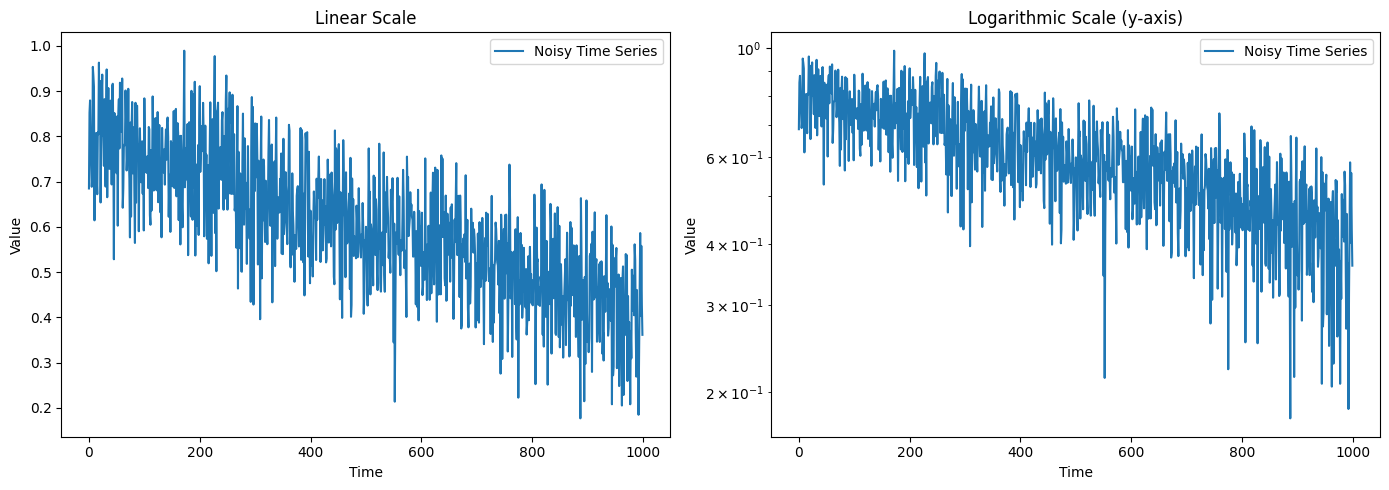

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create a time series of 1000 points
time_points = np.arange(1000)

# Values start at 0.8 and decrease to 0.4
values = np.linspace(0.8, 0.4, num=1000)

# Add significant noise
noise = np.random.normal(0, 0.1, size=1000)
noisy_values = values + noise

# Plot the time series in linear scale
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(time_points, noisy_values, label='Noisy Time Series')
plt.title('Linear Scale')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Plot the time series in ylog scale
plt.subplot(1, 2, 2)
plt.plot(time_points, noisy_values, label='Noisy Time Series')
plt.yscale('log')
plt.title('Logarithmic Scale (y-axis)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, RandRotate90d, ToTensord, ScaleIntensityRanged)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
import docx
from docx.shared import Inches

print("Importing Modules")

md_file_path = "./visualization.md"
starttime = time.time()

print("Defining the create_dataset function...")

def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

print("Setting data paths...")
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet(NEWTRY).pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet_optimizer(NEWTRY).pth"

print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest')
)

roi_size = (128, 128, 128)
print("Defining transformations...")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, 
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

print("Initializing data loaders...")
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

print("Initializing U-Net model...")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1500, eta_min=1e-6)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")

print("Setting up loss function and optimizer...")

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)
    saved_image_paths = []
    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):
            # ... [image processing code] ...
            plt.savefig(img_path)
            plt.close()
            saved_image_paths.append(img_path)
            # ... [markdown file update code] ...
    return saved_image_paths

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)
    saved_image_paths = []
    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):
            # ... [image processing code] ...
            plt.savefig(img_path)
            plt.close()
            saved_image_paths.append(img_path)
            # ... [markdown file update code] ...
    return saved_image_paths

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.savefig("./PNG/lossfunction.png")
    plt.close()

def plot_losses_log(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.savefig("./PNG/log-lossfunction.png")
    plt.close()

def select_images(image_paths, num_epochs, num_select=5):
    selected_indices = np.linspace(0, len(image_paths) - 1, num_select, dtype=int)
    return [image_paths[i] for i in selected_indices]

def create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images, output_path="experiment_report.docx"):
    doc = docx.Document()
    doc.add_paragraph("Experiment Description:")
    doc.add_paragraph(expdesc)
    doc.add_picture(log_loss_path, width=Inches(6))
    doc.add_paragraph("Training Images:")
    for img_path in selected_train_images:
        doc.add_picture(img_path, width=Inches(6))
    doc.add_paragraph("Validation Images:")
    for img_path in selected_val_images:
        doc.add_picture(img_path, width=Inches(6))
    doc.save(output_path)

num_epochs = 5  # Adjust as needed
train_losses = []
val_losses = []
all_train_images = []
all_val_images = []

print("Starting the training loop...")
for epoch in range(num_epochs):
    # ... [training loop code] ...

selected_train_images = select_images(all_train_images, num_epochs)
selected_val_images = select_images(all_val_images, num_epochs)
expdesc = "Your experiment description..."
log_loss_path = "./PNG/log-lossfunction.png"
create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images)

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")


Exception in thread Thread-14 (monitor_resources):
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Program Files\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ndnewcomb\AppData\Local\Temp\ipykernel_4592\1518861221.py", line 259, in monitor_resources
  File "C:\Users\ndnewcomb\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ndnewcomb\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_base.py", line 311, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "C:\Users\ndnewcomb\AppData\Roaming\Python\Python311\site-packages\matplotlib\axes\_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must hav

Validation Iteration: 0
Validation - Output shape: torch.Size([4, 3, 128, 128, 128]), Label shape: torch.Size([4, 1, 128, 128, 128])
VALIDATION-0_Epoch-0_iteration-0_batch-0.png
VALIDATION-0_Epoch-0_iteration-0_batch-1.png
VALIDATION-0_Epoch-0_iteration-0_batch-2.png
VALIDATION-0_Epoch-0_iteration-0_batch-3.png
Markdown file updated at ./visualization.md
VALIDATION-0_Epoch-0_iteration-0_batch-0.png
VALIDATION-0_Epoch-0_iteration-0_batch-1.png
VALIDATION-0_Epoch-0_iteration-0_batch-2.png
VALIDATION-0_Epoch-0_iteration-0_batch-3.png
Markdown file updated at ./visualization.md
Reading in the next batch - V [if any] ..
Validation Iteration: 1
Validation - Output shape: torch.Size([1, 3, 128, 128, 128]), Label shape: torch.Size([1, 1, 128, 128, 128])
VALIDATION-1_Epoch-0_iteration-0_batch-0.png
Markdown file updated at ./visualization.md
VALIDATION-1_Epoch-0_iteration-0_batch-0.png
Markdown file updated at ./visualization.md
Reading in the next batch - V [if any] ..

Epoch: 0, Current Learn

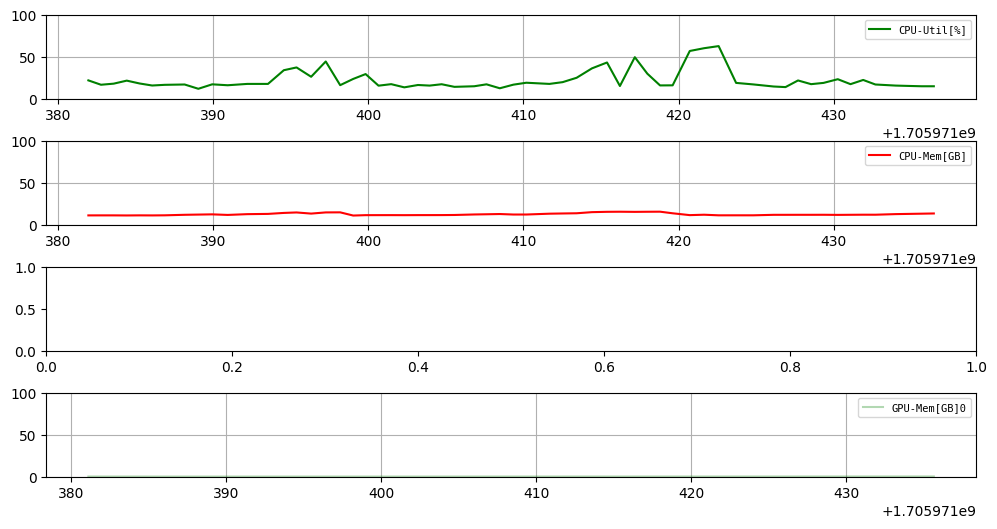

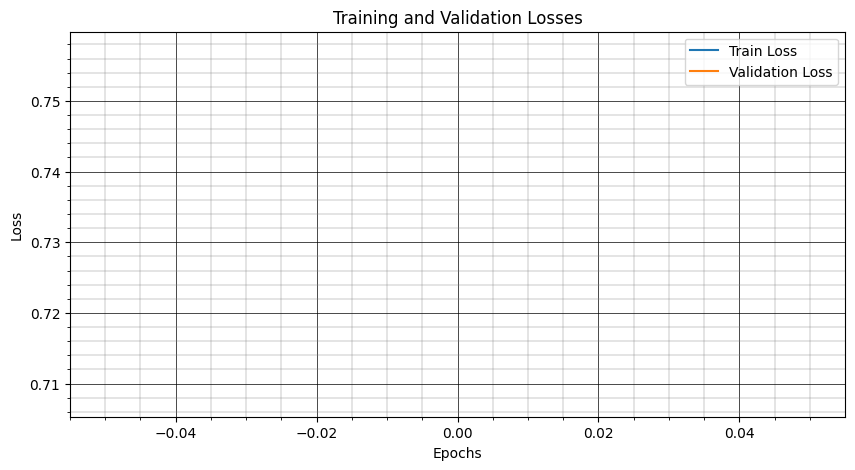

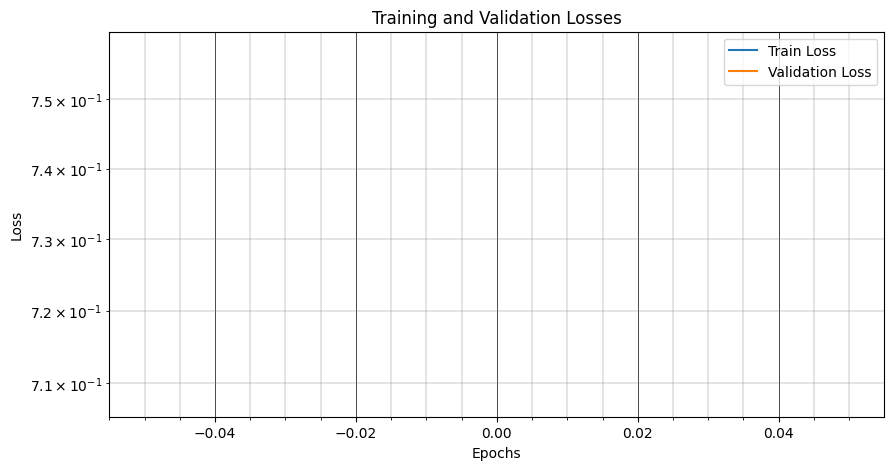

Epoch [1/2] - Train Loss: 0.7573, Val Loss: 0.7078
Elapsed: 2.50 Minutes

Reading in the first batch - T ..
Training Iteration: 0
Passing Through the Network
Output shape: torch.Size([2, 3, 128, 128, 128]), Label shape: torch.Size([2, 1, 128, 128, 128])
Label tensor values (sample): metatensor([0.])
Loss Backward
Stepping Optimizer
TRAINING-0_Epoch-1_iteration-0_batch-0.png
TRAINING-0_Epoch-1_iteration-0_batch-1.png
Markdown file updated at ./visualization.md
TRAINING-0_Epoch-0_iteration-1_batch-0.png
TRAINING-0_Epoch-0_iteration-1_batch-1.png
Markdown file updated at ./visualization.md

Reading in the next batch - T [if any] ..
Running the validation loop ..
Reading in the first batch - V ..
Validation Iteration: 0
Validation - Output shape: torch.Size([4, 3, 128, 128, 128]), Label shape: torch.Size([4, 1, 128, 128, 128])
VALIDATION-0_Epoch-1_iteration-0_batch-0.png
VALIDATION-0_Epoch-1_iteration-0_batch-1.png
VALIDATION-0_Epoch-1_iteration-0_batch-2.png
VALIDATION-0_Epoch-1_iteration

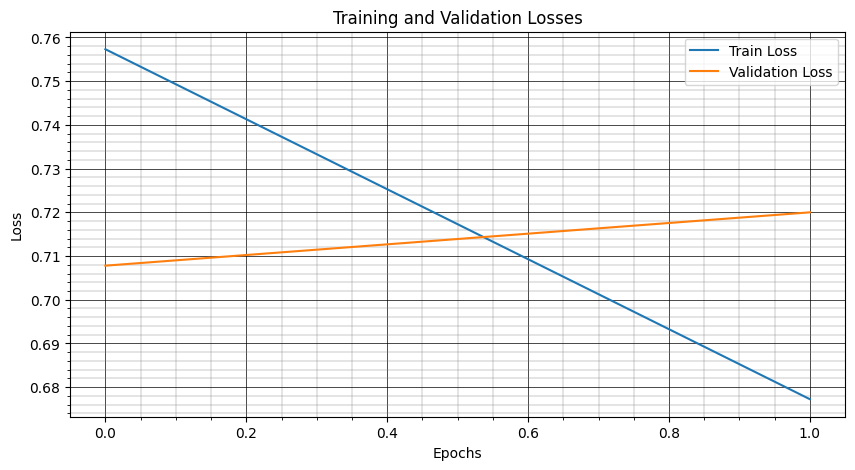

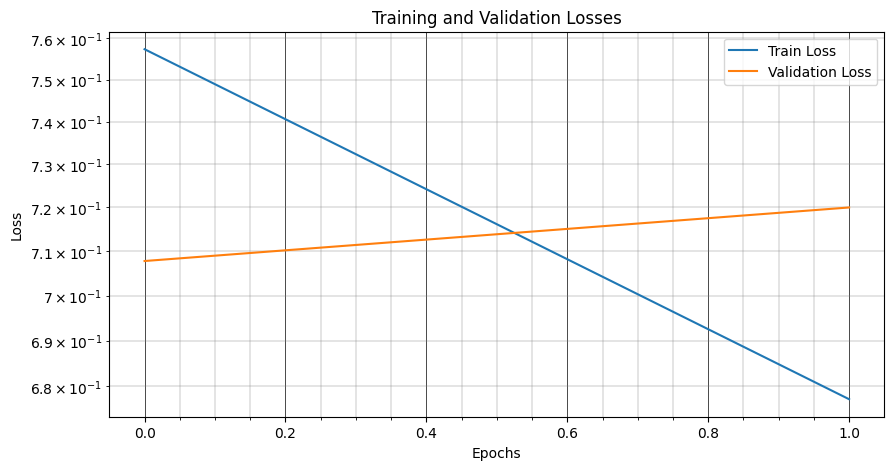

Epoch [2/2] - Train Loss: 0.6772, Val Loss: 0.7200
Elapsed: 4.95 Minutes


In [7]:
print("Importing Modules")
import os
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, CenterSpatialCropd,\
                               RandRotate90d, ToTensord, ScaleIntensityRanged, SpatialPadd)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader, pad_list_data_collate
print("Monai imported. Importing Torch")
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import time 
import numpy as np
import docx
from docx.shared import Inches
import threading
import matplotlib.pyplot as plt
import numpy as np
import psutil
import GPUtil
import time
from IPython.display import clear_output, display


# FUNCTIONS

def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)
    saved_train_image_paths = []


    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'TRAINING-{num_train}', fontsize=16)
                img_path = f"./PNG/TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()
                saved_train_image_paths.append(img_path)
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

    return saved_train_image_paths

    #             # Write to the markdown file
    #             md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    # print(f"Markdown file updated at {md_file_path}")

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)
    saved_valid_image_paths = []


    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'VALIDATION-{num}', fontsize=16)
                img_path = f"./PNG/VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()
                saved_valid_image_paths.append(img_path)
                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

    return saved_valid_image_paths

def select_images(image_paths, num_select=5):
    selected_indices = np.linspace(0, len(image_paths) - 1, num_select, dtype=int)
    return [image_paths[i] for i in selected_indices]

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/lossfunction.png")
    plt.close()
# Loss Plotting Function
def plot_losses_log(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
    plt.draw()
    plt.pause(0.001)
    plt.savefig("./PNG/log-lossfunction.png")
    plt.close()

def train_step(batch_data, model, loss_function, optimizer, device):
    # print("Reading in the images")
    # print(f"Processing filenames: {batch_data['filename']}")
    images, labels = batch_data['image'], batch_data['label']
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)

    print(f"Output shape: {outputs.shape}, Label shape: {labels.shape}")
    print("Label tensor values (sample):", labels[0, :, 0, 0, 0])
    # if torch.any(labels == 3):
        # print(f"Filename with label 3: {batch_data['filename']}")

    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs

def create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images, output_path="experiment_report.docx"):
    doc = docx.Document("experiment_report.docx")
    doc.add_paragraph("Experiment Description:")
    doc.add_paragraph(expdesc)
    doc.add_picture(log_loss_path, width=Inches(6))
    for img_path in selected_train_images + selected_val_images:
        doc.add_picture(img_path, width=Inches(6))
    doc.save(output_path)

def monitor_resources(stop_event, interval=0.2):
    fig, axs = plt.subplots(4, 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)

    LABEL = ['CPU-Util[%]', 'CPU-Mem[GB]', 'GPU-Util[%]', 'GPU-Mem[GB]']
    COLOR = ['green', 'red', 'orange', 'blue']
    LIMIT = [[0, 100], [0, 100], [0, 100], [0, 100]]

    timestamps, cpu_data, memory_data, gpu_memory_data, gpu_utilization_data = [], [], [], [], []

    while not stop_event.is_set():
        timestamp = time.time()
        cpu_percent = psutil.cpu_percent(interval=None)
        memory_usage = psutil.virtual_memory().used / (1024 ** 3)  # in GB
        gpus = GPUtil.getGPUs()
        gpu_memory = [gpu.memoryUsed/1024 for gpu in gpus]  # in GB
        gpu_utilization = [gpu.load*100 for gpu in gpus]

        timestamps.append(timestamp)
        cpu_data.append(cpu_percent)
        memory_data.append(memory_usage)
        gpu_memory_data.append(gpu_memory)
        gpu_utilization_data.append(gpu_utilization)

        kln = 60  # keep the last n data points
        timestamps = timestamps[-kln:]
        cpu_data = cpu_data[-kln:]
        memory_data = memory_data[-kln:]
        gpu_memory_data = [d[-kln:] for d in gpu_memory_data]
        gpu_utilization_data = [d[-kln:] for d in gpu_utilization_data]
        


        DATAX = [cpu_data, memory_data, gpu_utilization_data, gpu_memory_data]

        clear_output(wait=True)
        for k, ax in enumerate(axs):
            ax.clear()
            if k < 2:
                ax.plot(timestamps, DATAX[k], color=COLOR[k], label=LABEL[k])
            else:
                for j in range(len(DATAX[k][0])):
                    ax.plot(timestamps, [x[j] for x in DATAX[k]], color=COLOR[j], label=LABEL[k]+str(j), alpha=1 if j==1 else 0.3)

            ax.legend(prop={'family': 'monospace', 'size': 7.5}, loc='upper right')
            ax.set_ylim(LIMIT[k][0], LIMIT[k][1])
            ax.grid(True, which='both')

        display(fig)
        time.sleep(interval)

md_file_path = "./visualization.md"

expdesc = "Job 9: \n Train Images: 2 \n Validation Images: 5 \n Train Crop: RandSpatialCrop \n \
Validation Crop: RandSpatialCrop \n Epochs: 1500 \n Learning Rate: 1e-3 \n \
LR-Scheduling: Cosine Annealing(Tmax=1500,eta_min=1e-6) \n Size: (0.8, 0.8, 0.8) \n Batch Size: 4 \n ROI: (128, 128, 128)" # REMEBER TO CHANGE THIS EACH JOB

train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet(NEWTRY).pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet_optimizer(NEWTRY).pth"
starttime = time.time()

train_image_paths = []
val_image_paths = []


# Main training loop
num_epochs = 2 # Example value
display_interval = 1 # Example value

train_losses = []
val_losses = []



print("Defining the create_dataset function...")
# Function to create dataset


print("Setting data paths...")
# Set data paths

print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest') ###############################################################
)

# Define the size of the cropped region
roi_size = (128, 128, 128)
# roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, #####################################################################
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True) #collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=4) #collate_fn=pad_list_data_collate)

print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     num_gpus = torch.cuda.device_count()
#     print(f"Number of available GPUs: {num_gpus}")
#     if num_gpus > 1:
#         net = torch.nn.DataParallel(net)  # Wrap the model with DataParallel
#     net.to(device)
# else:
#     device = torch.device("cpu")
#     net.to(device)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #########################################
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1500, eta_min=1e-6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")


print("Setting up loss function and optimizer...")

# log_loss_path = "./PNG/log-lossfunction.png"



#THREADING
stop_event = threading.Event()
# monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event,))
# monitor_thread.start()
stop_event.clear()  # Ensure the stop event is cleared
monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event,))
monitor_thread.daemon = True
monitor_thread.start()

print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    

    # Training Phase
    net.train()
    num_train = 0
    print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
    print("\nReading in the first batch - T ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer, device)
        epoch_train_loss += loss
        # if iteration % display_interval == 0:
        if (epoch + 1) % 1 == 0 or epoch == 0:
            visualize_and_save_train(batch_data['image'], output, batch_data['label'], iteration, epoch, num_train) 
        train_image_batch_paths = visualize_and_save_train(batch_data['image'], output, batch_data['label'], epoch, iteration, num_train)
        train_image_paths.extend(train_image_batch_paths)

        print("\nReading in the next batch - T [if any] ..")
        num_train = num_train + 1
    train_losses.append(epoch_train_loss / len(train_loader))
    print("Running the validation loop ..")
    
    # Validation Phase
    net.eval()
    num = 0
    with torch.no_grad():
        print("Reading in the first batch - V ..")
        for batch_data in val_loader:
            print(f"Validation Iteration: {num}")
            # print(f"Processing filenames: {batch_data['filename']}")
            images, labels = batch_data['image'], batch_data['label']
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            print(f"Validation - Output shape: {outputs.shape}, Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            # if iteration % display_interval == 0:
            if (epoch + 1) % 1 == 0 or epoch == 0:
                visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], iteration, epoch, num) 
            val_image_batch_paths = visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], epoch, iteration, num)
            val_image_paths.extend(val_image_batch_paths)
            print("Reading in the next batch - V [if any] ..")
            num = num + 1
        print()    
    
    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step()
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch: {epoch}, Current Learning Rate: {current_lr}")
    # Plot Losses
    print("Plotting losses ..")
    plot_losses(train_losses, val_losses)
    plot_losses_log(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

selected_train_images = select_images(train_image_paths)
selected_val_images = select_images(val_image_paths)

# Call the function to create the document
log_loss_path = "./PNG/log-lossfunction.png"
create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images)
stop_event.set()
monitor_thread.join()

# plt.ioff()  # Turn off interactive mode
# plt.show()  # Display final plots

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")



In [5]:
print("Importing Modules")
import os
from monai.transforms import (Spacingd, Compose, LoadImaged, EnsureChannelFirstd, RandSpatialCropd, CenterSpatialCropd,\
                               RandRotate90d, ToTensord, ScaleIntensityRanged, SpatialPadd)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader, pad_list_data_collate
print("Monai imported. Importing Torch")
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import time 
import numpy as np
import docx
from docx.shared import Inches
import threading
import matplotlib.pyplot as plt
import numpy as np
import psutil
import GPUtil
import time
from IPython.display import clear_output, display


# FUNCTIONS

def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

def visualize_and_save_train(inputs, outputs, labels, iteration, epoch, num_train):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Red for arteries (1)
        [225, 0, 0]       # Blue for veins (2)
    ], dtype=np.uint8)
    saved_train_image_paths = []


    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'Training Image: Epoch {epoch}', fontsize=16)
                img_path = f"./PNG/TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"TRAINING-{num_train}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()
                saved_train_image_paths.append(img_path)
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

    return saved_train_image_paths

    #             # Write to the markdown file
    #             md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    # print(f"Markdown file updated at {md_file_path}")

def visualize_and_save_valid(inputs, outputs, labels, iteration, epoch, num):
    color_map = np.array([
        [255, 255, 255],  # White for background (0)
        [0, 0, 255],      # Blue for A (1)
        [255, 0, 0]       # Red for V (2)
    ], dtype=np.uint8)
    saved_valid_image_paths = []


    with open(md_file_path, "a") as md_file:
        for i in range(outputs.shape[0]):  # Iterate over the batch dimension
            if i < inputs.shape[0]:
                # Get the input image and normalize it for visualization
                input_slice = inputs[i, 0, :, :, :].detach().cpu().numpy()
                input_slice_mid = input_slice[input_slice.shape[0] // 2]  # Middle slice of the input volume
                # input_slice_mid_normalized = (input_slice_mid - clippingmin) / \
                #                             (clippingmax - clippingmin)

                # Get the label and prediction volumes
                label_volume = labels[i, 0].cpu().numpy().astype(np.uint8)
                output_volume = outputs[i].detach().cpu().numpy()
                predicted_labels_volume = np.argmax(output_volume, axis=0).astype(np.uint8)

                # Select the middle slice index after argmax reduction
                slice_idx = predicted_labels_volume.shape[0] // 2
                label_slice = label_volume[slice_idx]
                predicted_labels_slice = predicted_labels_volume[slice_idx]

                # Apply the color map to the label and prediction slices
                label_rgb_slice = color_map[label_slice]
                prediction_rgb_slice = color_map[predicted_labels_slice]

                # Create the plots
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_slice_mid, cmap='gray')
                ax[0].set_title("Input")
                ax[1].imshow(label_rgb_slice)
                ax[1].set_title("Ground Truth")
                ax[2].imshow(prediction_rgb_slice)
                ax[2].set_title("Prediction")
                fig.suptitle(f'Validation Image: Epoch {epoch}', fontsize=16)
                img_path = f"./PNG/VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png"
                print(f"VALIDATION-{num}_Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
                # Save the image
                plt.savefig(img_path)
                plt.close()
                saved_valid_image_paths.append(img_path)
                # Write to the markdown file
                md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")

    print(f"Markdown file updated at {md_file_path}")

    return saved_valid_image_paths

def select_images(image_paths, num_select=5):
    selected_indices = np.linspace(0, len(image_paths) - 1, num_select, dtype=int)
    return [image_paths[i] for i in selected_indices]

# def plot_losses(train_losses, val_losses, save_path):
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Losses')
#     plt.legend()
#     plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
#     plt.minorticks_on()
#     plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
#     plt.draw()
#     plt.pause(0.001)
#     plt.savefig(save_path)
#     print(f"Log Loss plot saved at: {save_path}")
#     plt.close()
# # Loss Plotting Function
# def plot_losses_log(train_losses, val_losses, save_path):
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.yscale('log')
#     plt.title('Training and Validation Losses')
#     plt.legend()
#     plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
#     plt.minorticks_on()
#     plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
#     plt.draw()
#     plt.pause(0.001)
#     plt.savefig(save_path)
#     print(f"Loss plot saved at: {save_path}")
#     plt.close()

def plot_losses(train_losses, val_losses, save_path):
    # Ensure the directory exists yes
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
    # plt.draw()
    # plt.pause(0.001)
    plt.savefig(save_path)
    print(f"Log Loss plot saved at: {save_path}")
    plt.close()

def plot_losses_log(train_losses, val_losses, save_path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, color="black")
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray')
    # plt.draw()
    # plt.pause(0.001)
    plt.savefig(save_path)
    print(f"Loss plot saved at: {save_path}")
    plt.close()
def train_step(batch_data, model, loss_function, optimizer, device):
    # print("Reading in the images")
    # print(f"Processing filenames: {batch_data['filename']}")
    images, labels = batch_data['image'], batch_data['label']
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)

    print(f"Output shape: {outputs.shape}, Label shape: {labels.shape}")
    print("Label tensor values (sample):", labels[0, :, 0, 0, 0])
    # if torch.any(labels == 3):
        # print(f"Filename with label 3: {batch_data['filename']}")

    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs

# def create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images, output_path="experiment_report.docx"):
#     doc = docx.Document("experiment_report.docx")
#     doc.add_paragraph("Experiment Description:")
#     doc.add_paragraph(expdesc)
#     doc.add_picture(log_loss_path, width=Inches(6))
#     for img_path in selected_train_images + selected_val_images:
#         doc.add_picture(img_path, width=Inches(6))
#     doc.save(output_path)
def create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images):
    ########################################################################
    parent_directory = os.path.dirname(os.getcwd())
    output_path = os.path.join(parent_directory, 'JobReport.docx')

    # Check if the file exists. If yes, open the existing file; if no, create a new one
    if os.path.exists(output_path):
        doc = docx.Document(output_path)
        print(f"Appending to existing document: {output_path}")
    else:
        doc = docx.Document()
        print(f"Creating new document: {output_path}")

    # Append content to the document
    doc.add_paragraph("Experiment Description:")
    doc.add_paragraph(expdesc)
    doc.add_picture(log_loss_path, width=Inches(6))

    for img_path in selected_train_images + selected_val_images:
        doc.add_picture(img_path, width=Inches(6))

    # Save the document
    doc.save(output_path)

    # Print the path where the file was updated or created
    print(f"Document updated/created: {output_path}")

# def monitor_resources(stop_event, interval=0.2):
#     fig, axs = plt.subplots(4, 1, figsize=(12, 6))
#     fig.subplots_adjust(hspace=0.5)

#     LABEL = ['CPU-Util[%]', 'CPU-Mem[GB]', 'GPU-Util[%]', 'GPU-Mem[GB]']
#     COLOR = ['green', 'red', 'orange', 'blue']
#     LIMIT = [[0, 100], [0, 100], [0, 100], [0, 100]]

#     timestamps, cpu_data, memory_data, gpu_memory_data, gpu_utilization_data = [], [], [], [], []

#     while not stop_event.is_set():
#         timestamp = time.time()
#         cpu_percent = psutil.cpu_percent(interval=None)
#         memory_usage = psutil.virtual_memory().used / (1024 ** 3)  # in GB
#         gpus = GPUtil.getGPUs()
#         gpu_memory = [gpu.memoryUsed/1024 for gpu in gpus]  # in GB
#         gpu_utilization = [gpu.load*100 for gpu in gpus]

#         timestamps.append(timestamp)
#         cpu_data.append(cpu_percent)
#         memory_data.append(memory_usage)
#         gpu_memory_data.append(gpu_memory)
#         gpu_utilization_data.append(gpu_utilization)

#         kln = 60  # keep the last n data points
#         timestamps = timestamps[-kln:]
#         cpu_data = cpu_data[-kln:]
#         memory_data = memory_data[-kln:]
#         gpu_memory_data = [d[-kln:] for d in gpu_memory_data]
#         gpu_utilization_data = [d[-kln:] for d in gpu_utilization_data]
        


#         DATAX = [cpu_data, memory_data, gpu_utilization_data, gpu_memory_data]

#         clear_output(wait=True)
#         for k, ax in enumerate(axs):
#             ax.clear()
#             if k < 2:
#                 ax.plot(timestamps, DATAX[k], color=COLOR[k], label=LABEL[k])
#             else:
#                 for j in range(len(DATAX[k][0])):
#                     ax.plot(timestamps, [x[j] for x in DATAX[k]], color=COLOR[j], label=LABEL[k]+str(j), alpha=1 if j==1 else 0.3)

#             ax.legend(prop={'family': 'monospace', 'size': 7.5}, loc='upper right')
#             ax.set_ylim(LIMIT[k][0], LIMIT[k][1])
#             ax.grid(True, which='both')

#         display(fig)
#         time.sleep(interval)

md_file_path = "./visualization.md"

expdesc = "Job 9: \n Train Images: 2 \n Validation Images: 5 \n Train Crop: RandSpatialCrop \n \
Validation Crop: RandSpatialCrop \n Epochs: 1500 \n Learning Rate: 1e-3 \n \
LR-Scheduling: Cosine Annealing(Tmax=1500,eta_min=1e-6) \n Size: (0.8, 0.8, 0.8) \n Batch Size: 4 \n ROI: (128, 128, 128)" # REMEBER TO CHANGE THIS EACH JOB

train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet(NEWTRY).pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet_optimizer(NEWTRY).pth"
starttime = time.time()

train_image_paths = []
val_image_paths = []


# Main training loop
num_epochs = 2 # Example value
display_interval = 1 # Example value

train_losses = []
val_losses = []



print("Defining the create_dataset function...")
# Function to create dataset


print("Setting data paths...")
# Set data paths

print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

downsampling_transform = Spacingd(
    keys=['image', 'label'], 
    pixdim=(0.8, 0.8, 0.8), 
    mode=('bilinear', 'nearest') ###############################################################
)

# Define the size of the cropped region
roi_size = (128, 128, 128)
# roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform, #####################################################################
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    downsampling_transform,
    # SpatialPadd(keys=['image', 'label'], spatial_size=roi_size, method='symmetric'),  # Add padding here
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ScaleIntensityRanged(keys=['image'], a_min=-1100, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label']),
])

print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True) #collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=4) #collate_fn=pad_list_data_collate)

print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     num_gpus = torch.cuda.device_count()
#     print(f"Number of available GPUs: {num_gpus}")
#     if num_gpus > 1:
#         net = torch.nn.DataParallel(net)  # Wrap the model with DataParallel
#     net.to(device)
# else:
#     device = torch.device("cpu")
#     net.to(device)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #########################################
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1500, eta_min=1e-6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

if not os.path.exists("./model"):
    os.makedirs("./model", exist_ok=True)
if os.path.exists(model_save_path):
    net.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model state loaded successfully.")
if os.path.exists(optimizer_save_path):
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Optimizer state loaded successfully.")


print("Setting up loss function and optimizer...")

# log_loss_path = "./PNG/log-lossfunction.png"



#THREADING
# stop_event = threading.Event()
# # monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event,))
# # monitor_thread.start()
# stop_event.clear()  # Ensure the stop event is cleared
# monitor_thread = threading.Thread(target=monitor_resources, args=(stop_event,))
# monitor_thread.daemon = True
# monitor_thread.start()

print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    

    # Training Phase
    net.train()
    num_train = 0
    print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")
    print("\nReading in the first batch - T ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer, device)
        epoch_train_loss += loss
        # if iteration % display_interval == 0:
        if (epoch + 1) % 1 == 0 or epoch == 0:
            visualize_and_save_train(batch_data['image'], output, batch_data['label'], iteration, epoch, num_train) 
        train_image_batch_paths = visualize_and_save_train(batch_data['image'], output, batch_data['label'], epoch, iteration, num_train)
        train_image_paths.extend(train_image_batch_paths)

        print("\nReading in the next batch - T [if any] ..")
        num_train = num_train + 1
    train_losses.append(epoch_train_loss / len(train_loader))
    print("Running the validation loop ..")
    
    # Validation Phase
    net.eval()
    num = 0
    with torch.no_grad():
        print("Reading in the first batch - V ..")
        for batch_data in val_loader:
            print(f"Validation Iteration: {num}")
            # print(f"Processing filenames: {batch_data['filename']}")
            images, labels = batch_data['image'], batch_data['label']
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            print(f"Validation - Output shape: {outputs.shape}, Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            # if iteration % display_interval == 0:
            if (epoch + 1) % 1 == 0 or epoch == 0:
                visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], iteration, epoch, num) 
            val_image_batch_paths = visualize_and_save_valid(batch_data['image'], outputs, batch_data['label'], epoch, iteration, num)
            val_image_paths.extend(val_image_batch_paths)
            print("Reading in the next batch - V [if any] ..")
            num = num + 1
        print()    
    
    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step()
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch: {epoch}, Current Learning Rate: {current_lr}")
    # Plot Losses
    print("Plotting losses ..")
    loss_plot_path = "./PNG/lossfunction.png"
    log_loss_plot_path = "./PNG/log-lossfunction.png"
    plot_losses(train_losses, val_losses, loss_plot_path)
    plot_losses_log(train_losses, val_losses, log_loss_plot_path)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

selected_train_images = select_images(train_image_paths)
selected_val_images = select_images(val_image_paths)

# Call the function to create the document
# log_loss_path = "./PNG/log-lossfunction.png"
create_word_document(expdesc, log_loss_plot_path, selected_train_images, selected_val_images)
# stop_event.set()
# monitor_thread.join()



torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)

print(f"Elapsed: {(time.time()-starttime)/60:.2f} Minutes")



Importing Modules
Monai imported. Importing Torch
Defining the create_dataset function...
Setting data paths...
Creating datasets...
Defining transformations...
Elapsed: 0.00 Minutes
Initializing data loaders...
Initializing U-Net model...
Elapsed: 0.00 Minutes
Model state loaded successfully.
Optimizer state loaded successfully.
Setting up loss function and optimizer...
Starting the training loop...
Elapsed: 0.02 Minutes

Reading in the first batch - T ..
Training Iteration: 0
Passing Through the Network
Output shape: torch.Size([2, 3, 128, 128, 128]), Label shape: torch.Size([2, 1, 128, 128, 128])
Label tensor values (sample): metatensor([0.])
Loss Backward
Stepping Optimizer
TRAINING-0_Epoch-0_iteration-0_batch-0.png
TRAINING-0_Epoch-0_iteration-0_batch-1.png
Markdown file updated at ./visualization.md
TRAINING-0_Epoch-0_iteration-0_batch-0.png
TRAINING-0_Epoch-0_iteration-0_batch-1.png
Markdown file updated at ./visualization.md

Reading in the next batch - T [if any] ..
Running th

NameError: name 'log_loss_path' is not defined

In [14]:
import GPUtil
GPUtil.showUtilization()



| ID | GPU | MEM |
------------------
|  0 | 13% |  4% |


KeyboardInterrupt: 

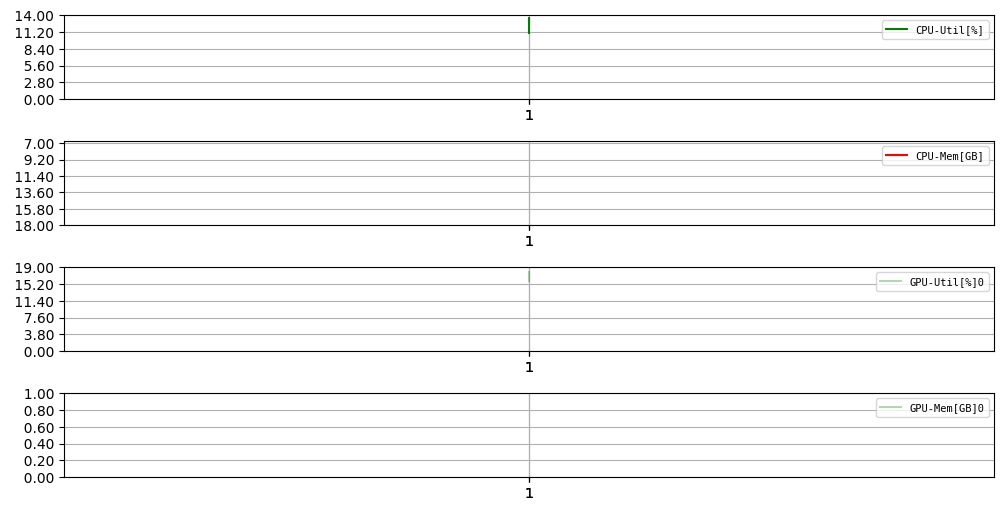

In [2]:
# RESOURCE MONITOR

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import clear_output, display
import numpy as np
import psutil
import GPUtil
import time

fig, axs = plt.subplots(4, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)

interval = 0.2 # Set the interval in seconds for data collection
timestamps, cpu_data, memory_data, gpu_memory_data, gpu_utilization_data = [], [], [], [], []

LABEL = ['CPU-Util[%]', 'CPU-Mem[GB]', 'GPU-Util[%]', 'GPU-Mem[GB]']
COLOR = ['green', 'red', 'orange', 'blue']
LIMIT = [[0,100],[17.8,1000],[0,100],[0,80]]

i = 0
while (True):    
    timestamp = i + 1    
    cpu_percent = psutil.cpu_percent(interval=None)
    memory_usage = psutil.virtual_memory().used / (1024 ** 3)  # in GB #.virtual_memory().percent
    gpus = GPUtil.getGPUs()
    gpu_memory = [gpu.memoryUsed/1024 for gpu in gpus] # this one is a list
    gpu_utilization = [gpu.load*100 for gpu in gpus] # this one is a list

    timestamps.append(timestamp)
    cpu_data.append(cpu_percent)
    memory_data.append(memory_usage)
    gpu_memory_data.append(gpu_memory) # list of 4-len-lists
    gpu_utilization_data.append(gpu_utilization) # list of 4-len-lists

    kln = 60 # keep the last n data points
    timestamps = timestamps[-kln:]
    cpu_data = cpu_data[-kln:]
    memory_data = memory_data[-kln:]
    gpu_memory_data = gpu_memory_data[-kln:] # works fine with list of lists # shape: Nx4
    gpu_utilization_data = gpu_utilization_data[-kln:] # works fine with list of lists # shape: Nx4

    DATAX = [cpu_data, memory_data, gpu_utilization_data, gpu_memory_data]

    clear_output(wait=True)    
    for k, ax in enumerate(axs): # Iterate over the subplots
        
        ax.clear() # Remove data already added to the axes        
        if   k< 2: ax.plot(timestamps, DATAX[k], color=COLOR[k], label=LABEL[k])
        elif k>=2:
            for j in range(len(DATAX[k][0])): # if there are more than 4 gpus, COLOR will spit error
                ax.plot(timestamps, [x[j] for x in DATAX[k]], color=COLOR[j],
                        label=LABEL[k]+str(j), alpha=1 if j==1 else 0.3)

        ax.legend(prop={'family': 'monospace', 'size': 7.5}, loc='upper right')
        ax.set_ylim(LIMIT[k][0], None) # LIMIT[k][1] ####
        KLIMIT = [np.ceil(x) for x in ax.get_ylim()]
        
        # Create evenly spaced gridlines
        x_ticks = timestamps
        y_ticks = np.linspace(KLIMIT[0], KLIMIT[1], num=6)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(['{:6.2f}'.format(x) for x in ax.get_yticks()])
        ax.grid(True, which='both')
        # Remove spines: ax.spines['left'].set_visible(False) #right #top #bottom

    display(fig)
    time.sleep(interval)

In [13]:
import threading
import time

def long_running_task():
    print("Long-running task started.")
    # Simulating a long task
    time.sleep(10) 
    print("Long-running task finished.")

def quick_task():
    print("Quick task executed.")

# Creating the threads
long_task_thread = threading.Thread(target=long_running_task)
quick_task_thread = threading.Thread(target=quick_task)

# Starting the long-running thread
long_task_thread.start()

# Running the quick task multiple times while the long task is running
while long_task_thread.is_alive():
    quick_task_thread = threading.Thread(target=quick_task)
    quick_task_thread.start()
    quick_task_thread.join()  # Optionally wait for the quick task to finish
    time.sleep(1)  # Delay before the next quick task, adjust as necessary

# Optional: Wait for the long-running task to finish if it's still running
long_task_thread.join()


Long-running task started.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Quick task executed.
Long-running task finished.


In [10]:
expdesc = "Job 9: \n Train Images: 2 \n Validation Images: 5 \n Train Crop: RandSpatialCrop \n \
Validation Crop: RandSpatialCrop \n Epochs: 1500 \n Learning Rate: 1e-3 \n \
LR-Scheduling: Cosine Annealing(Tmax=1500,eta_min=1e-6) \n Size: (0.8, 0.8, 0.8) \n Batch Size: 4 \n ROI: (128, 128, 128)" # REMEBER TO CHANGE THIS EACH JOB



In [11]:
def create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images, output_path="experiment_report.docx"):
    doc = docx.Document()
    doc.add_paragraph("Experiment Description:")
    doc.add_paragraph(expdesc)
    doc.add_picture(log_loss_path, width=Inches(6))
    for img_path in selected_train_images + selected_val_images:
        doc.add_picture(img_path, width=Inches(6))
    doc.save(output_path)

# Call the function to create the document
log_loss_path = "./PNG/log-lossfunction.png"
create_word_document(expdesc, log_loss_path, selected_train_images, selected_val_images)

In [2]:
! pip3 --version

pip 23.3.2 from C:\Users\ndnewcomb\AppData\Roaming\Python\Python311\site-packages\pip (python 3.11)

